In [1]:
import os
import findspark

from alkansya.data_generators import generate_ohlcv
from alkansya.utils import get_configurations

from pyspark.sql import SparkSession
from pyspark.sql import functions as f

import pandas as pd
from datetime import datetime

os.environ["ENV"] = "DEV"
findspark.init()

cfg = get_configurations()

path_to_silver = cfg["path_to_silver"]
path_to_gold = cfg["path_to_gold"]

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [2]:
dfs = spark.read.parquet(f"{path_to_gold}/cleaned")

for resolution in [15,30,60,1440]:
    generate_ohlcv(dfs, resolution, path_to_gold)

In [5]:
dfs = spark.read.parquet(f"{path_to_gold}/resolution_1440min")
dfs.show()

+-------------------+-------+-------+-------+-------+--------+-------------+
|               time|   open|   high|    low|  close|  volume|currency_pair|
+-------------------+-------+-------+-------+-------+--------+-------------+
|2019-01-09 08:00:00|1.27576|1.27797|1.27066|1.27395| 91172.0|       GBPUSD|
|2019-01-10 08:00:00|1.27418|1.28035|1.27156|1.27889|161779.0|       GBPUSD|
|2019-01-11 08:00:00|1.27868|1.27939|1.27279|1.27607|141804.0|       GBPUSD|
|2019-01-14 08:00:00|1.28533|1.28639|1.28404|1.28508| 23999.0|       GBPUSD|
|2019-01-15 08:00:00|  1.285|1.29303|1.28184|1.29135|124252.0|       GBPUSD|
|2019-01-16 08:00:00|1.29148|1.29148|1.26679|1.28681|163631.0|       GBPUSD|
|2019-01-17 08:00:00| 1.2867| 1.2897|1.28405|1.28753|130260.0|       GBPUSD|
|2019-01-18 08:00:00|1.28781|1.30005| 1.2832|1.29756|140608.0|       GBPUSD|
|2019-01-21 08:00:00|1.28768|1.28792|1.28476|1.28695| 23695.0|       GBPUSD|
|2019-01-22 08:00:00|1.28682|1.29103|1.28301|1.28731|110491.0|       GBPUSD|

In [4]:
from alkansya.feature_engineering import spark_query as query

dfs = spark.read.parquet(f"{path_to_gold}/resolution_60min")

dfs_temp = dfs.select(
    "*",
    query.simple_moving_average(window_size_days=3),
    query.exponential_moving_average(window_size_days=3),
    query.volatility(window_size_days=3),
    query.support_and_resistance(window_size_days=28)
)

dfs_temp.show()

+-------------------+-------+-------+-------+-------+------+-------------+------------------+------------------+--------------------+
|               time|   open|   high|    low|  close|volume|currency_pair|         sma_2_day|         ema_2_day|    volatility_2_day|
+-------------------+-------+-------+-------+-------+------+-------------+------------------+------------------+--------------------+
|2019-01-07 15:00:00|0.71342|0.71349|0.71331|0.71336| 348.0|       AUDUSD|0.7133600115776062|              null|                null|
|2019-01-07 16:00:00| 0.7134|0.71401|0.71318|0.71335|3762.0|       AUDUSD|0.7133550047874451|0.7133540034294129|3.540335274915098...|
|2019-01-07 17:00:00|0.71345|0.71388|0.71258|0.71349|4598.0|       AUDUSD|0.7134000062942505|0.7134314349719456|2.603517874806313E-5|
|2019-01-07 18:00:00|0.71317|0.71382| 0.7123|0.71332|7013.0|       AUDUSD|0.7133800089359283|0.7133664168747775|1.881914011405410...|
|2019-01-07 19:00:00|0.71369| 0.7145|0.71258|0.71418|4918.0|  

In [23]:
dfs.withColumn("maximum_swing_per_day", (1-f.col("low")/f.col("high"))).orderBy(f.col("maximum_swing_per_day").desc()).filter(f.col("time")>"2021-01-01").show()

+-------------------+-------+-------+-------+-------+--------+-------------+---------------------+
|               time|   open|   high|    low|  close|  volume|currency_pair|maximum_swing_per_day|
+-------------------+-------+-------+-------+-------+--------+-------------+---------------------+
|2022-09-26 08:00:00|1.07953|1.08445|1.03463|1.05463|102078.0|       GBPUSD|  0.04594039854343601|
|2022-09-23 08:00:00|144.799|145.895| 140.34|142.276|333221.0|       USDJPY| 0.038075381417421617|
|2022-09-27 08:00:00|1.05331|1.09294|1.05222|1.07671|354150.0|       GBPUSD|  0.03725729406227696|
|2022-12-20 08:00:00|136.193|137.474|132.663|132.781|173064.0|       USDJPY| 0.034995742270155894|
|2022-09-29 08:00:00|1.06483| 1.0915|1.05385|1.08076|382653.0|       GBPUSD|  0.03449380450288908|
|2022-06-17 08:00:00|1.21467|1.24065|1.20409|1.23067|305992.0|       GBPUSD| 0.029468469665649977|
|2022-10-14 08:00:00| 1.1088|1.13792|1.10561|1.13201|317786.0|       GBPUSD|  0.02839391906084132|
|2022-10-2

In [24]:
df = pd.read_parquet(f"{path_to_gold}/resolution_1440min")
df['theoretical_max_swing'] = 1-df["low"]/df["high"]
df['theoretical_swing_open_close'] = df["open"]/df["close"]

# Exclude 2020 pandemic start
df = df[df["time"]>datetime(2021, 1,1)].sort_values("theoretical_swing_open_close", ascending=False)

<Axes: >

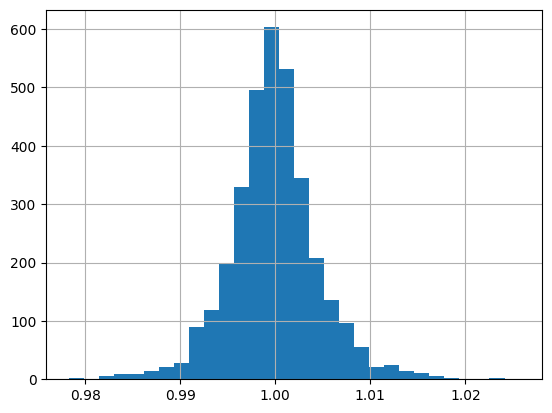

In [25]:
df['theoretical_swing_open_close'].hist(bins=30)